In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob

In [2]:
def plot(image):
    plt.figure(figsize=(8,8))
    if len(image.shape)==2 or image.shape[-1]==1:
        plt.imshow(image, cmap="gray")
    else:
        plt.imshow(image)
    plt.show()
        

In [3]:
read = lambda x: cv2.imread(x)[:,:,::-1]
resize = lambda x, y: cv2.resize(x, (0,0), fx=y, fy=y)
gray = lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)

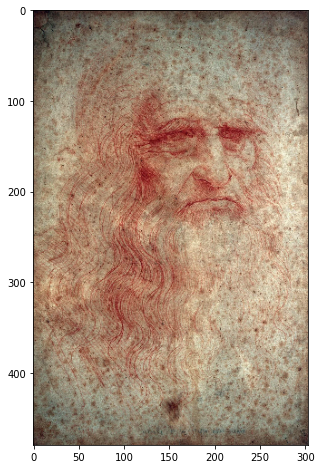

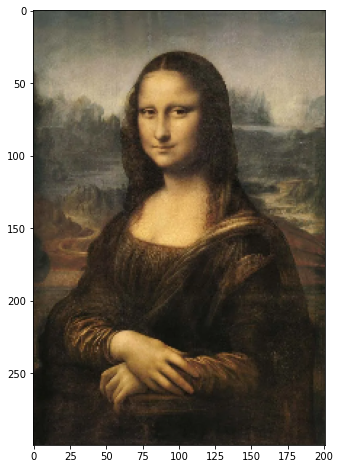

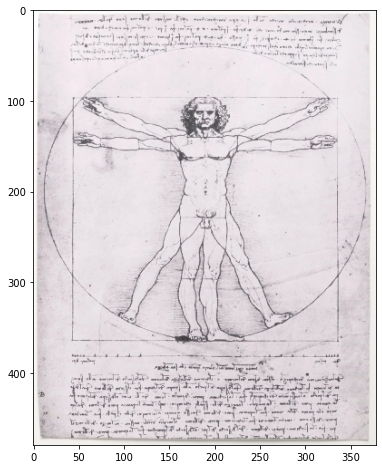

In [30]:
images = glob.glob("./Data/*")
for image in images:
    image = read(image)
    image = resize(image, .3)
    plot(image)

# Convolution Function

In [102]:
def convolve(image, kernel):
    '''Perform 2D convolution on single channel image'''
    kernel_height, kernel_width = kernel.shape
    image_height, image_width = image.shape[:2]
    filter_applied = []
    row_loop = image_height - kernel_height + 1
    row_itr = 0
    while row_itr<row_loop:
        filter_row = []
        col_loop = image_width - kernel_width + 1
        col_itr = 0
        while col_itr<col_loop: 
            image_patch = image[row_itr:row_itr+kernel_height, col_itr:col_itr+kernel_width]
            new_pixel = np.sum(np.multiply(image_patch, kernel))
            filter_row.append(new_pixel)
            col_itr += 1
        filter_applied.append(filter_row)
        row_itr += 1
    return np.array(filter_applied)

# Gausian blur

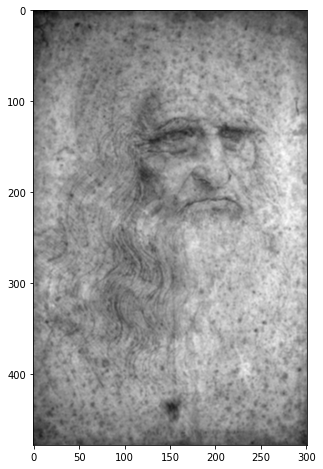

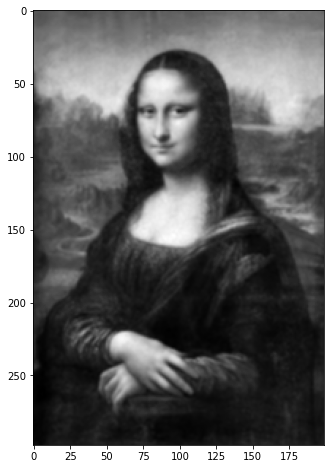

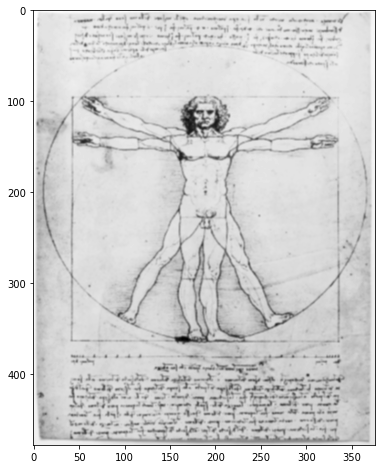

In [98]:
gausian_kernel = np.array(
    [
        [1,2,1],
        [2,4,2],
        [1,2,1],
    ]
)

images = glob.glob("./Data/*")
# Applying gausian blur
for image in images:
    image = read(image)
    image = resize(image, .3)
    gray_image = gray(image)
    conv = convolve(gray_image, gausian_kernel)
    conv = conv/conv.max() * 255
    plot(conv)

# Sharp filter

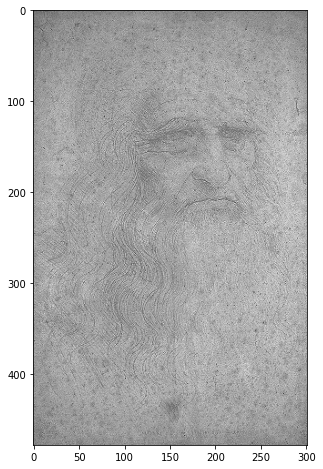

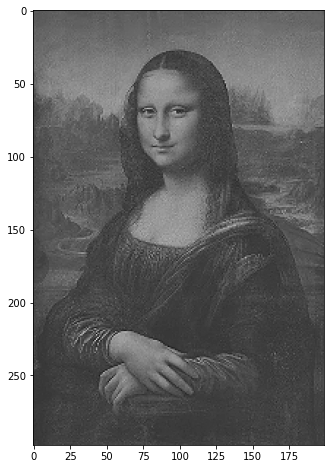

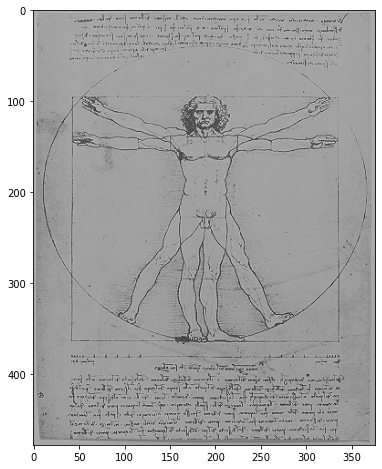

In [103]:
sharp_kernel = np.array(
   [
       [  0 , -.5 ,   0 ],
       [-.5 ,   3 , -.5 ],
       [  0 , -.5 ,   0 ]
   ]
)

images = glob.glob("./Data/*")
# Applying sharp filter
for image in images:
    image = read(image)
    image = resize(image, .3)
    gray_image = gray(image)
    conv = convolve(gray_image, sharp_kernel)
    conv = conv/conv.max() * 255
    plot(conv)

# Edge Detection

## Horizontal edge

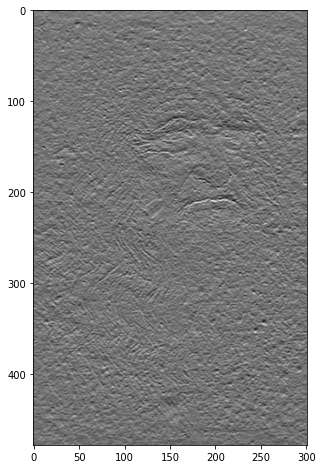

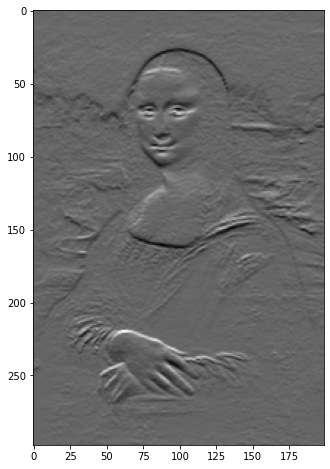

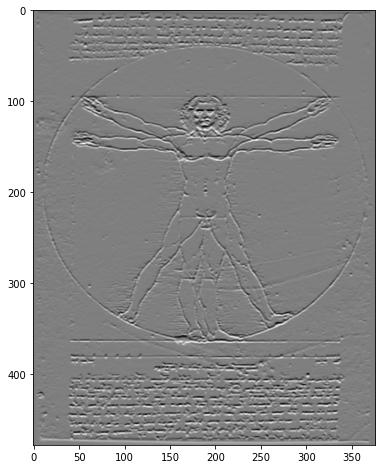

In [100]:
horizontal_kernel = np.array(
   [
       [-1, -2, -1],
       [0, 0, 0],
       [1, 2, 1]
   ]
)

images = glob.glob("./Data/*")
# Applying Horizontal edge
for image in images:
    image = read(image)
    image = resize(image, .3)
    gray_image = gray(image)
    conv = convolve(gray_image, horizontal_kernel)
    conv = conv/conv.max() * 255
    plot(conv)

## Vertical edge

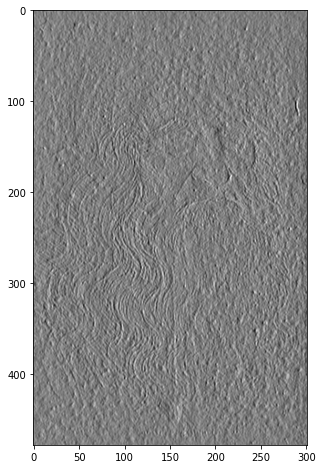

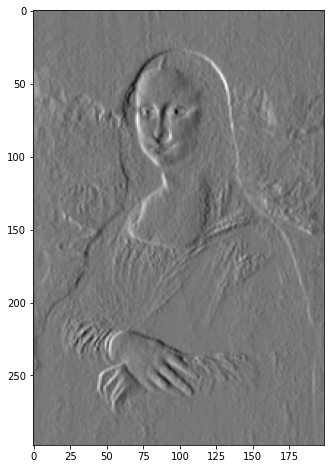

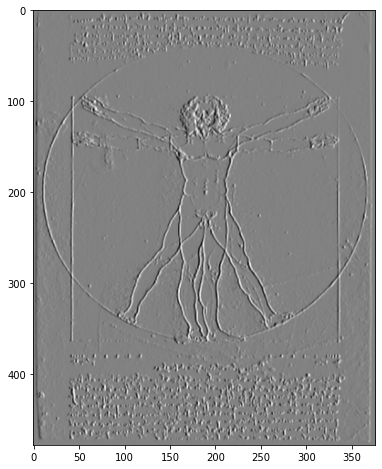

In [104]:
vertical_kernel = np.array(
    [
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]
    ]
)

images = glob.glob("./Data/*")
# Applying vertical edge
for image in images:
    image = read(image)
    image = resize(image, .3)
    gray_image = gray(image)
    conv = convolve(gray_image, vertical_kernel)
    conv = conv/conv.max() * 255
    plot(conv)

## Sobel filter

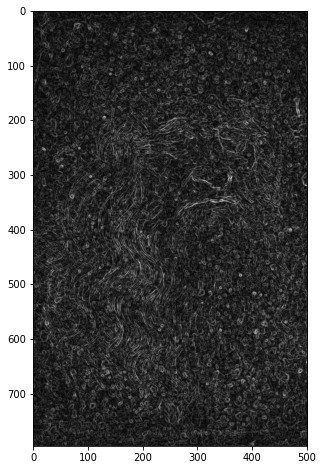

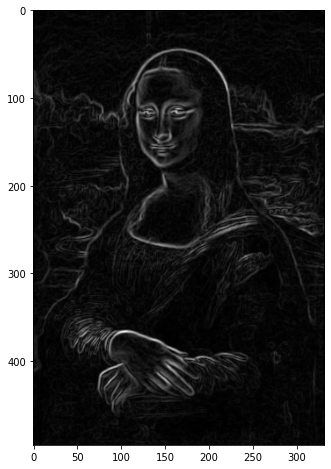

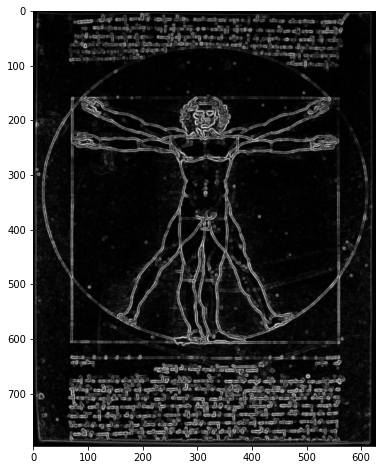

In [96]:
# Sobel edge
#  np.hypot returns the square root of sum of square of arguments passed.

images = glob.glob("./Data/*")
for image in images:
    image = read(image)
    image = resize(image, .5)
    gray_image = gray(image)
    blur = convolve(gray_image, gausian_kernel)
    v_conv = convolve(blur, vertical_kernel)
    h_conv = convolve(blur, horizontal_kernel)
    conv = np.hypot(h_conv, v_conv)
    conv = conv/conv.max() * 255
    plot(conv)

## Canny filter

Output of sobel edge detection we can see all edges are not same. some are thin some are thick, means intensity are not same.

In [93]:
# tan(ang) = sin(ang)/cos(ang) = y/x
# ang = tan_inv(y/x)
# ================
# tan(pi/6) = 1/sqrt(3)
# tan_inv(1/sqrt(3)) = pi/6
# This tan_inv finds angle given sides and called arctan
# arctan2 preserves the direction in each quadrant
print(np.arctan(np.pi), np.arctan2(np.pi, 0))

1.2626272556789115 1.5707963267948966


In [107]:
# Sobel function
def apply_sobel(image):
    image = read(image)
    image = resize(image, .3)
    gray_image = gray(image)
    blur = convolve(gray_image, gausian_kernel)
    v_conv = convolve(blur, vertical_kernel)
    h_conv = convolve(blur, horizontal_kernel)
    conv = np.hypot(h_conv, v_conv)
    conv = conv/conv.max() * 255
    theta = np.arctan2(v_conv, h_conv) # Theta is the direction of edges
    return conv, theta

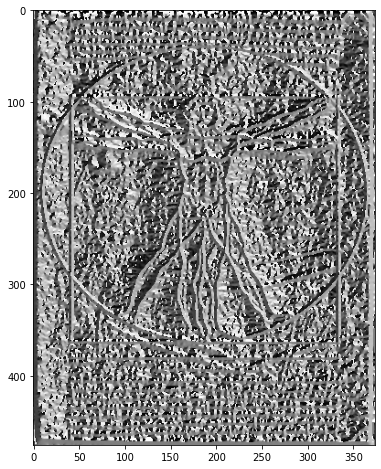

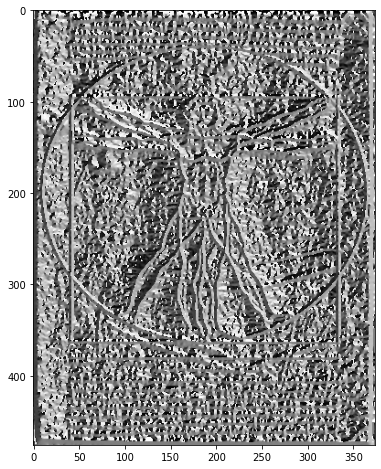

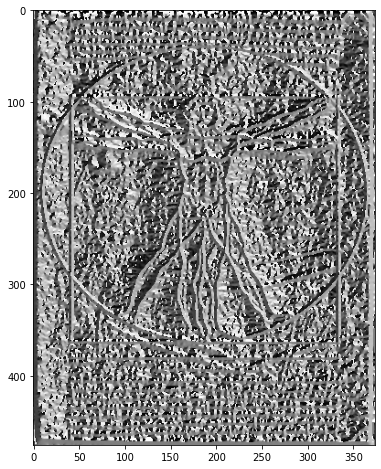

In [112]:
# Ploting direction
images = glob.glob("./Data/*")
for image in images:
    sobel_edge, direction = apply_sobel(image)
    plot(directions)

<b> Non-Maximum Suppression </b><br>
The final image should have thin edges. Thus, we must perform non-maximum suppression to thin out the edges.
The principle is simple: the algorithm goes through all the points on the gradient intensity matrix and finds the pixels with the maximum value in the edge directions.

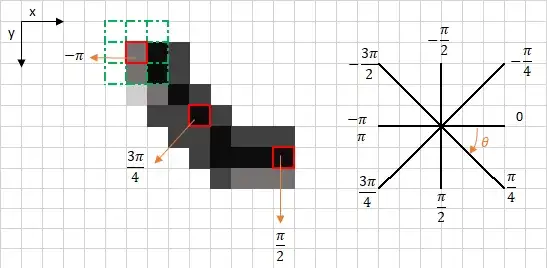

source: https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123

The pixel (i, j) is being processed, and the pixels on the same direction are highlighted in blue (i, j-1) and (i, j+1). If one those two pixels are more intense than the one being processed, then only the more intense one is kept. 

<b>Double threshold</b><br>
The double threshold step aims at identifying 3 kinds of pixels: strong, weak, and non-relevant:
- Strong pixels are pixels that have an intensity so high that we are sure they contribute to the final edge.
- Weak pixels are pixels that have an intensity value that is not enough to be considered as strong ones, but yet not small enough to be considered as non-relevant for the edge detection.
- Other pixels are considered as non-relevant for the edge.

<b>Edge Tracking by Hysteresis </b><br>
Based on the threshold results, the hysteresis consists of transforming weak pixels into strong ones, if and only if at least one of the pixels around the one being processed is a strong one

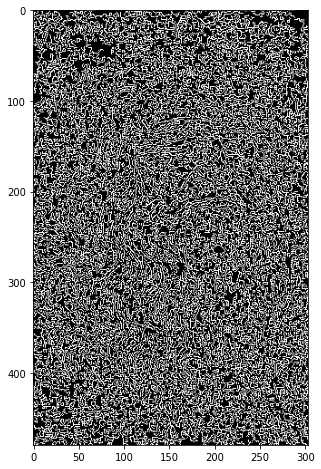

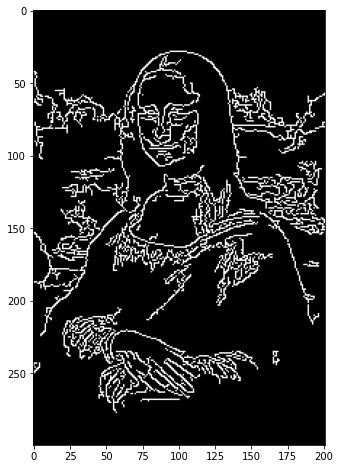

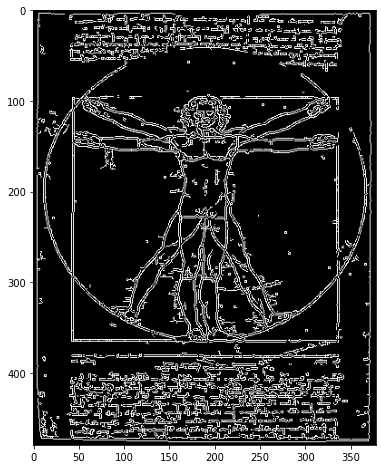

In [144]:

images = glob.glob("./Data/*")
for image in images:
    image = read(image)
    image = resize(image, .3)
    gray_image = gray(image)
    canny_out = cv2.Canny(gray_image, 50, 150)
    plot(canny_out)

<b>Canny with Aperture_size</b><br>
This is an optional parameter that is used to specify the order of the Sobel filter used to calculate the gradient in the Canny algorithm. The default value is 3 and its value should be odd between 3 and 7. You can increase the Aperture size when you want to detect more detailed features.

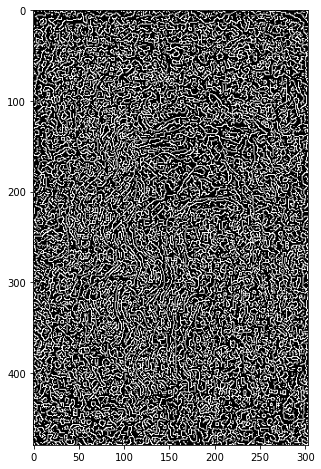

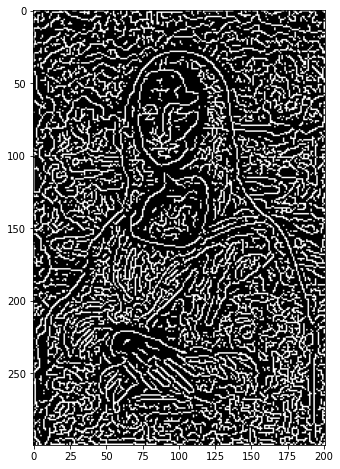

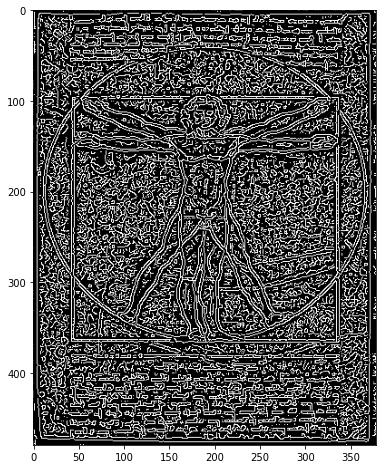

In [151]:

images = glob.glob("./Data/*")
for image in images:
    image = read(image)
    image = resize(image, .3)
    gray_image = gray(image)
    canny_out = cv2.Canny(gray_image, 50, 150, apertureSize=7)
    plot(canny_out)

<b>Canny with L2Gradient</b><br>
It’s a boolean parameter that specifies if you want to calculate the usual gradient equation or the L2Gradient algorithm. Again, it’s an optional parameter. L2gradient is nothing my sqrt(gradient_x_square + gradient_y_square) whereas L1gradient is just abs(gradient_x) + abs(gradient_y).

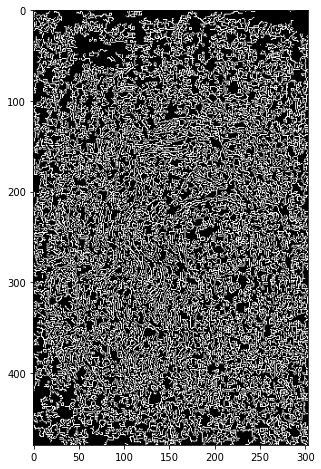

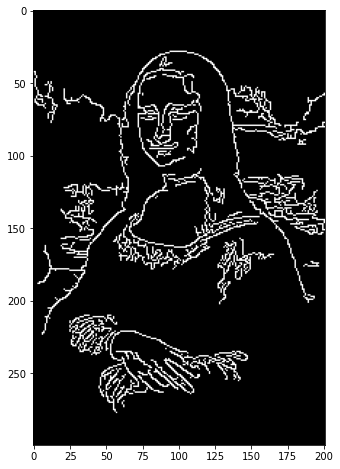

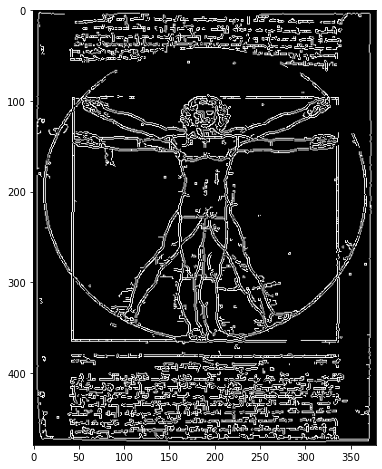

In [153]:

images = glob.glob("./Data/*")
for image in images:
    image = read(image)
    image = resize(image, .3)
    gray_image = gray(image)
    canny_out = cv2.Canny(gray_image, 50, 150, L2gradient =True)
    plot(canny_out)